In [2]:
%pip install upsetplot
%pip install pandas


Defaulting to user installation because normal site-packages is not writeable
  distutils: /private/var/folders/hl/spm99ds95mld0q7b29wq6t4h0000gn/T/pip-build-env-vctq8wrb/normal/lib/python3.9/site-packages
  sysconfig: /Library/Python/3.9/site-packages
  distutils: /private/var/folders/hl/spm99ds95mld0q7b29wq6t4h0000gn/T/pip-build-env-vctq8wrb/normal/lib/python3.9/site-packages
  sysconfig: /Library/Python/3.9/site-packages
  user = False
  home = None
  root = None
  prefix = '/private/var/folders/hl/spm99ds95mld0q7b29wq6t4h0000gn/T/pip-build-env-vctq8wrb/normal'
  distutils: /private/var/folders/hl/spm99ds95mld0q7b29wq6t4h0000gn/T/pip-build-env-vctq8wrb/overlay/lib/python3.9/site-packages
  sysconfig: /Library/Python/3.9/site-packages
  distutils: /private/var/folders/hl/spm99ds95mld0q7b29wq6t4h0000gn/T/pip-build-env-vctq8wrb/overlay/lib/python3.9/site-packages
  sysconfig: /Library/Python/3.9/site-packages
  user = False
  home = None
  root = None
  prefix = '/private/var/folders/h

/Users/lsh2004630/Library/Python/3.9/lib/python/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/Users/lsh2004630/Library/Python/3.9/lib/python/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewid

<Figure size 18000x12000 with 0 Axes>

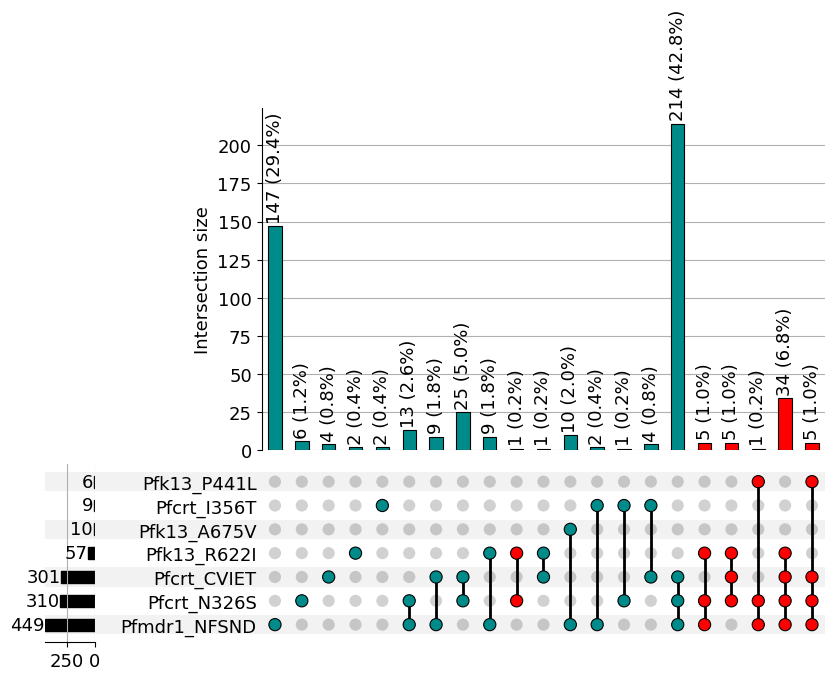

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_memberships

# Load the datasets
file_path1 = 'Upset_intersection Plot Dataset_SEPT_25 -_no_dhfr_dhps.csv'
data1 = pd.read_csv(file_path1)


def preprocess_data(data):
    data['Gene_Mutation'] = data['Gene'] + "_" + data['Mutation']
    return data

def generate_upset_plot(data, title, filename_base):

    # Define color mappings for specific mutations
    red_mutations = {"Pfcrt_N326S", "Pfcrt_I356T"}
    orange_mutations = {"Pfk13_R622I", "Pfk13_P441L", "Pfk13_A675V"}

    # Combine columns and create binary matrix
    binary_matrix = pd.crosstab(data['Sample_ID'], data['Gene_Mutation']).astype(bool).astype(int)
    gene_mutation_names = binary_matrix.columns.tolist()
    upset_data = binary_matrix.groupby(list(binary_matrix.columns)).size()

    # Calculate percentages for each intersection size
    total_samples = len(data['Sample_ID'].unique())
    intersection_labels = {index: f"{count} ({count / total_samples * 100:.1f}%)"
                           for index, count in upset_data.items()}

    # Generate combinations for the UpSet plot
    gene_mutation_combinations = []
    for index, count in upset_data.items():
        combination = [gene_mutation_names[i] for i, value in enumerate(index) if value]
        gene_mutation_combinations.extend([combination] * count)

    # Prepare data in format for UpSet plot
    upset_data_reformatted = from_memberships(gene_mutation_combinations)

    # Plot settings for publication
    plt.figure(figsize=(15, 10), dpi=1200)  # Higher DPI for publication quality
    upset_plot = UpSet(
        upset_data_reformatted,
        subset_size='count',
        show_counts=True,  # We will modify labels later
        intersection_plot_elements=13,
        element_size=25
    )

    # Customize subsets appearance based on specific mutation combinations
    for subset, size in upset_data.items():
        subset_mutations = [gene_mutation_names[i] for i, value in enumerate(subset) if value]
        facecolor = 'darkcyan'  # Default color

        # Check if any of the Pfcrt mutations are present AND if any of the Pfk13 mutations are present
        if any(mutation in red_mutations for mutation in subset_mutations) and \
           any(mutation in orange_mutations for mutation in subset_mutations):
            facecolor = 'red'

        # Style the subset using `present` or `absent` instead of `subset`
        # Convert subset (a tuple of 0s and 1s) to a list of present mutations
        present_mutations = [gene_mutation_names[i] for i, value in enumerate(subset) if value == 1]

        # Use `present` to target subsets containing specific mutations
        upset_plot.style_subsets(present=present_mutations, facecolor=facecolor, edgecolor='black', linewidth=0.8)

    # Plot the UpSet plot
    upset_plot.plot()

    # Customize plot font labels size and colors for publication
    plt.rcParams['font.size'] = 13  # General font size for publication
    plt.rcParams['font.family'] = 'sans-serif'  # Default sans-serif font
    plt.rcParams['axes.labelcolor'] = 'black'  # Axis label color
    plt.rcParams['xtick.color'] = 'black'  # X-tick color
    plt.rcParams['ytick.color'] = 'black'  # Y-tick color

    # Modify intersection labels to include percentage, set smaller font size, center align, and rotate labels
    for text in plt.gca().texts:
        if text.get_text().isdigit():
            count = int(text.get_text())
            percentage = (count / total_samples) * 100
            text.set_text(f"{count} ({percentage:.1f}%)")
            text.set_fontsize(13)  # Set smaller font size for intersection labels
            text.set_rotation(90)  # Rotate labels 90 degrees
            text.set_ha('center')  # Center align labels for a balanced appearance

    # Customize title with larger font and bold for publication
    plt.suptitle(title, fontsize=15, fontweight="bold", color='black')

    # Improve layout
    plt.tight_layout()

    # Save plot to file
    plt.savefig(f"{filename_base}.tiff", format='tiff', dpi=1200)
    plt.savefig(f"{filename_base}.pdf", format='pdf', dpi=1200)

    plt.show()

# Preprocess data by combining 'Gene' and 'Mutation' columns
data1 = preprocess_data(data1)

# Generate UpSet plots for both datasets with publication-ready appearance and save to file
generate_upset_plot(data1, "", "upset_plot")